## Table Of Contents
<font size=3rem>
    
0 -**[ INTRO](#INTRODUCTION)<br>**
1 -**[ OBTAIN](#OBTAIN)**<br>
2 -**[ PREPROCESSING](#PREPROCESSING)**<br>
4 -**[ MODEL](#MODEL)**<br>
5 -**[ INTERPRET](#INTERPRET)**<br>
6 -**[ CONCLUSIONS & RECCOMENDATIONS](#Conclusions-&-Recommendations)<br>**
</font>
___

# INTRODUCTION

- Student: Cody Freese
- Pace: Self Paced
- Jeff Herman

- Pneumonia Chest Xray Image Classification
    - Objective
        - First I need to decide on:
            - Accuracy
            - Precision
            - Recall
            - F1 Score
        - Priority
            - (1) Do not want to tell a sick person they are healthy
            
            - (2) Accurately identify pneumonia
            - (3) Tell healthy person they are sick

## Import Tools

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
import cv2
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

Using TensorFlow backend.


## FUNCTIONS

In [2]:
def get_num_pixels(pixel_path):
    '''
    Gets width and height of image
    :param pixel_path: String
    :return width, height: Tuple of Int
    '''
    
    width, height = Image.open(pixel_path).size
    return width, height

In [3]:
def get_image_pixels_and_paths(path):
    '''
    Joins the classes of called picture pixel count for total of called class
    :param path: String
    :return None: prints out pixel dimensions
    '''
    
    # Print width/height for each image in Normal Test Path
    for path, subdirs, files in os.walk(path):
        for name in files:
            image_path = os.path.join(path,name)
            print(get_num_pixels(image_path))

# OBTAIN

In [4]:
#Home Directory
home_path = r'C:\Users\c_fre\Learn.co\Module_4_Project\Image-Classification\chest_xray'

#Train Directory
train_path = os.path.join(home_path,'train')

#Validation Directory
val_path = os.path.join(home_path,'val')

#Test Directory
test_path = os.path.join(home_path,'test')

#Train Subdirectories
normal_train_path = os.path.join(train_path,'NORMAL')

pneumonia_train_path = os.path.join(train_path,'PNEUMONIA')

#Validation Subdirectories
normal_val_path = os.path.join(val_path,'NORMAL')

pneumonia_val_path = os.path.join(val_path,'PNEUMONIA')

#Test Subdirectories

normal_test_path = os.path.join(test_path,'NORMAL')

pneumonia_test_path = os.path.join(test_path,'PNEUMONIA')

In [5]:
#Observe Contents
print('Directory Contents:',os.listdir(home_path))
print('train Contents:',os.listdir(train_path))
print('val Contents:',os.listdir(val_path))
print('test Contents:',os.listdir(test_path))

Directory Contents: ['test', 'train', 'val']
train Contents: ['NORMAL', 'PNEUMONIA']
val Contents: ['NORMAL', 'PNEUMONIA']
test Contents: ['NORMAL', 'PNEUMONIA']


In [6]:
#Cases in Training Sets
print("Number of cases in Training:",len(os.listdir(normal_train_path)) +len(os.listdir(pneumonia_train_path)))

print("Number of Pneumonia cases in Training:",len(os.listdir(pneumonia_train_path)))

print("Number of Normal cases in Training:",len(os.listdir(normal_train_path)))

Number of cases in Training: 5216
Number of Pneumonia cases in Training: 3875
Number of Normal cases in Training: 1341


In [7]:
# Cases in Validation Sets
print("Number of cases in Validation:",len(os.listdir(normal_val_path)) +len(os.listdir(pneumonia_val_path)))

print("Number of Pneumonia cases in Validation:",len(os.listdir(pneumonia_val_path)))

print("Number of Normal cases in Validation:",len(os.listdir(normal_val_path)))

Number of cases in Validation: 16
Number of Pneumonia cases in Validation: 8
Number of Normal cases in Validation: 8


In [8]:
#Cases in Test Sets
print("Number of cases in Test:",len(os.listdir(normal_test_path)) +len(os.listdir(pneumonia_test_path)))

print("Number of Pneumonia cases in Test:",len(os.listdir(pneumonia_test_path)))

print("Number of Normal cases in Test:",len(os.listdir(normal_test_path)))

Number of cases in Test: 624
Number of Pneumonia cases in Test: 390
Number of Normal cases in Test: 234


In [9]:
# #Total number of Normal Cases
print("Total number of Normal cases:",
      len(os.listdir(normal_test_path))+
      len(os.listdir(normal_train_path))+
      len(os.listdir(normal_val_path)))

#Total number of Pneumonia Cases
print("Total number of Pneumonia cases:",
      len(os.listdir(pneumonia_test_path))+
      len(os.listdir(pneumonia_train_path))+
      len(os.listdir(pneumonia_val_path)))

Total number of Normal cases: 1583
Total number of Pneumonia cases: 4273


In [10]:
# get_image_pixels_and_paths(test_path)
# get_image_pixels_and_paths(train_path)
# get_image_pixels_and_paths(val_path)

In [11]:
# Validation Pixel Size
get_image_pixels_and_paths(val_path)

(1776, 1416)
(1272, 1040)
(1736, 1416)
(1288, 928)
(1240, 1104)
(1328, 1104)
(1632, 1225)
(1564, 1302)
(968, 592)
(1072, 712)
(1152, 664)
(1416, 944)
(1256, 864)
(1016, 656)
(1192, 952)
(1664, 1128)


- Average of Validation images
- (1348,1003)
- 6 images losing width data
- 8 images losing height data

# PREPROCESSING

In [12]:
# #Dataset for model
# train_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
#                                                                 labels='inferred',
#                                                                 label_mode='binary')

# val_dataset = keras.preprocessing.image_dataset_from_directory(val_path,
#                                                                labels='inferred',
#                                                                label_mode='binary')

# test_dataset = keras.preprocessing.image_dataset_from_directory(test_path,
#                                                                labels='inferred',
#                                                                label_mode='binary')

In [13]:
# print(train_dataset)
# print(val_dataset)
# print(test_dataset)

In [14]:
# All below attempted to fit from ImageDataGenerator. Find way to make above fit with below

In [15]:
# Mini-Batch Gradient Descent
batch_size = 32
# img_size = (1000,800)
# batch_size = 10

# EXPLORE

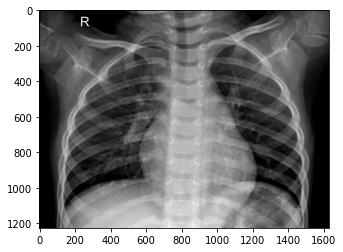

In [16]:
# Test Image
img_path = 'C:/Users/c_fre/Learn.co/Module_4_Project/Image-Classification/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'

image_name = cv2.imread(img_path)

plt.imshow(image_name)

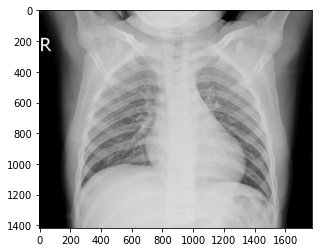

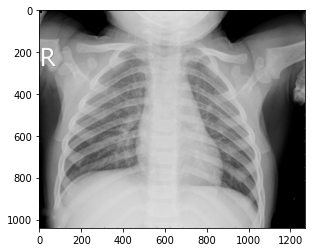

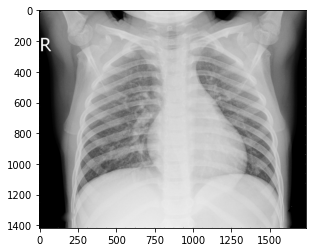

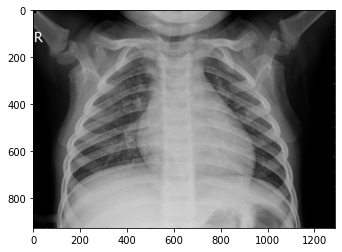

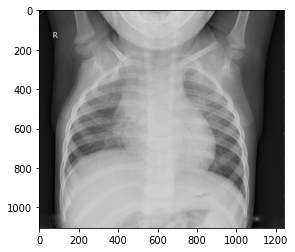

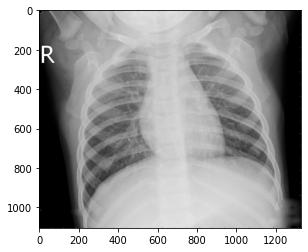

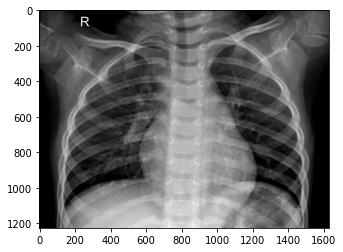

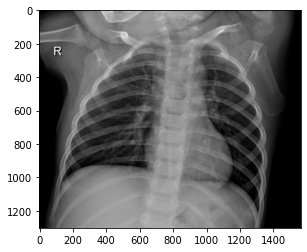

In [17]:
normal_val_images = os.listdir(normal_val_path)
for image_name in normal_val_images:
    image_path = os.path.join(normal_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

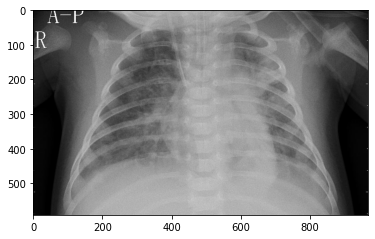

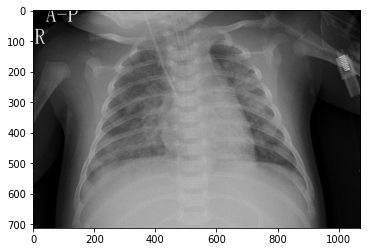

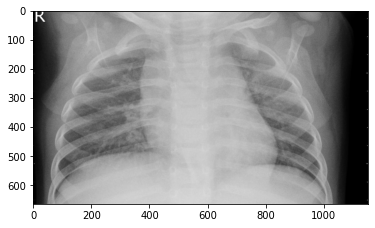

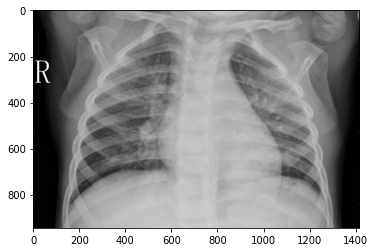

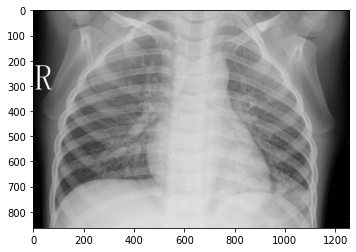

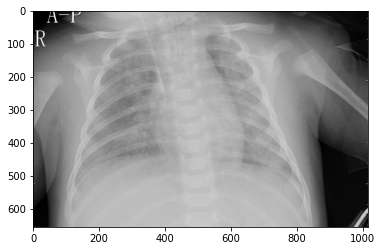

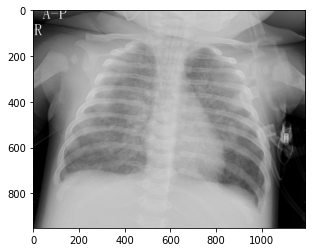

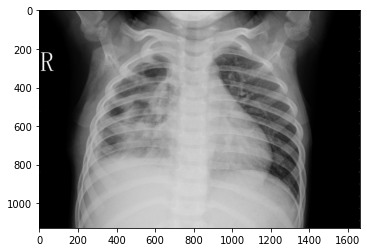

In [18]:
pneumonia_val_images = os.listdir(pneumonia_val_path)
for image_name in pneumonia_val_images:
    image_path = os.path.join(pneumonia_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

# MODELING

In [19]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0)

val_datagen = ImageDataGenerator(rescale=1 / 255.0)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [20]:
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    subset='training',
    shuffle=True,
    seed=7539541
)
valid_generator = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    subset='validation',
    shuffle=True,
    seed=7539541
)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=1,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)

Found 5216 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
model = keras.Sequential()

In [23]:
# 2D Convolution Layer over Images
model.add(keras.layers.Conv2D(32,
                              kernel_size=(3,3),
                              activation='relu',
                              input_shape=(100, 100, 3)))

In [24]:
# Downsample Input Along Spatial Dimensions
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

In [25]:
# Fuse paths without losing scalability
model.add(keras.layers.Flatten())

In [26]:
# Full input, Reduce Gradient Vanish, Stop Inactive Neurons
model.add(keras.layers.Dense(16,
                             activation='relu'))

In [27]:
# Full input, Binary output
model.add(keras.layers.Dense(1,
                             activation='sigmoid'))

In [28]:
# Loss Function, Binary Classification, Adaptive Moment Estimation
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 76832)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1229328   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,230,241
Trainable params: 1,230,241
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(train_generator,
          validation_data = valid_generator,
          steps_per_epoch = train_generator.n//train_generator.batch_size,
          validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=10)

Epoch 1/10
163/163 [==============================] - 45s 272ms/step - loss: 0.4450 - accuracy: 0.8108
Epoch 2/10
163/163 [==============================] - 44s 270ms/step - loss: 0.2288 - accuracy: 0.9057
Epoch 3/10
163/163 [==============================] - 44s 270ms/step - loss: 0.1978 - accuracy: 0.9227
Epoch 4/10
163/163 [==============================] - 44s 272ms/step - loss: 0.1623 - accuracy: 0.9404
Epoch 5/10
163/163 [==============================] - 44s 270ms/step - loss: 0.1634 - accuracy: 0.9340
Epoch 6/10
163/163 [==============================] - 44s 270ms/step - loss: 0.1511 - accuracy: 0.9379
Epoch 7/10
163/163 [==============================] - 44s 269ms/step - loss: 0.1520 - accuracy: 0.9408
Epoch 8/10
163/163 [==============================] - 44s 269ms/step - loss: 0.1553 - accuracy: 0.9402
Epoch 9/10
163/163 [==============================] - 44s 270ms/step - loss: 0.1560 - accuracy: 0.9413
Epoch 10/10
163/163 [==============================] - 44s 271ms/step - l

In [31]:
model2 = keras.Sequential()

In [32]:
# 1st conv
model2.add(keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), input_shape = (100, 100, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.MaxPool2D(pool_size = (2, 2)))

In [33]:
# 2nd conv
model2.add(keras.layers.SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.MaxPool2D(pool_size = (2, 2)))

In [34]:
# 3rd conv
model2.add(keras.layers.SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

In [35]:
# 4th conv
model2.add(keras.layers.SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.MaxPool2D(pool_size = (2, 2)))
model2.add(keras.layers.Dropout(rate = 0.2))

In [36]:
# 5th
model2.add(keras.layers.SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.MaxPool2D(pool_size = (2, 2)))
model2.add(keras.layers.Dropout(rate = 0.2))

In [37]:
# Connected layer
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(units = 512, activation = 'relu'))
model2.add(keras.layers.Dropout(rate = 0.7))
model2.add(keras.layers.Dense(units = 128, activation = 'relu'))
model2.add(keras.layers.Dropout(rate = 0.5))
model2.add(keras.layers.Dense(units = 64, activation = 'relu'))
model2.add(keras.layers.Dropout(rate = 0.3))

In [38]:
# Output layer
model2.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))

In [39]:
#Model Summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 50, 50, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 50, 50, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)       

In [40]:
# Sequntial Compile
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [41]:
# CONTINUE WORK HERE

In [42]:
# Callback
checkpoint = ModelCheckpoint(filepath = 'Pneumonia.h5', save_best_only = True, save_weights_only = True)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 2, mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 1, mode = 'min')

NameError: name 'ModelCheckpoint' is not defined

In [ ]:
# Fit data to cnn model
cnn = model.fit_generator(training_set,
                          epochs = epochs,
                          steps_per_epoch = training_set.samples // batch_size,
                          validation_data = test_set,
                          validation_steps = test_set.samples // batch_size,
                          callbacks = [checkpoint, lr_reduce])   

In [ ]:
# model.load_weights('./Pneumonia.h5')

In [ ]:
#Input Test
rand_img = np.random.randint(0, len(os.listdir(val_dataset +'/'+ 'val/PNEUMONIA/')))
rand_img_path = val_dataset + '/'+'val/PNEUMONIA/' + os.listdir(val_dataset +'/'+ 'val/PNEUMONIA/')[rand_img]

img = plt.imread(rand_img_path)
img = cv2.resize(img, (img_size, img_size))
img = np.dstack([img, img, img])
img = img.astype('float32') / 255
result = model.predict(np.expand_dims(image.img_to_array(img), axis = 0))  

if result[0][0] >0.5:
  prediction = 'Pnuemonia'
else:
  prediction = 'Normal'
  
print(f'Predicted : ' + prediction)
print ('Actual : Pnuemonia')

image = plt.imread(rand_img_path)
plt.imshow(image)
plt.title('Pneumonia')
plt.imshow(image, cmap = 'gray')

In [ ]:
# Metrics
tn, fp, fn, tp = mat.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

In [ ]:
print('Train Metric:')
print('Train accuracy: {}%'.format(np.round(cnn.history['accuracy'][-1]*100, 2)))

In [ ]:
scores = model.evaluate(validation_generator)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

In [ ]:
hist=model.fit(
        train_generator,
        steps_per_epoch=82,
        epochs=100,
        validation_data=valid_generator,
        validation_steps=82)

In [ ]:
# Accuracy 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:
# Loss 
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()